# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from py3langid.langid import LanguageIdentifier, MODEL_FILE
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn import metrics

import warnings

# Suppress FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning)

# Data

## Original Data

In [2]:
train = pd.read_csv('data/competition_2024/subtask1.csv').drop(columns='Unnamed: 0')

train.head()

,id,text,label
0,15442,Es un tribunal de suprema instanza que forma p...,generated
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human
2,12777,Doug mcadam es un científico estadista estadou...,generated
3,63467,"El president de la generalitat, carles puigdem...",generated
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated


## Identifying languages

In [3]:
identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE)
identifier.set_languages(['en', 'es', 'pt', 'gl', 'eu', 'ca'])

# English (en)
# Spanish (es)
# Portuguese (pt)
# Galician (gl)
# Basque (eu)
# Catalan (ca)

identifier.classify(train.loc[0, 'text'])

('ca', -4691.199)

In [4]:
def detect_language(text):
    return identifier.classify(text)[0]

# Create the new column
train['detected_language'] = train['text'].apply(detect_language)

train

,id,text,label,detected_language
0,15442,Es un tribunal de suprema instanza que forma p...,generated,ca
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human,ca
2,12777,Doug mcadam es un científico estadista estadou...,generated,es
3,63467,"El president de la generalitat, carles puigdem...",generated,ca
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated,es
...,...,...,...,...
109658,76637,"Bere burua egokitzen saiatu zuen, aurreko mome...",generated,eu
109659,107183,"Benquerida compañeira e amiga, para nós é moi ...",human,gl
109660,144741,"The irish president has signed the ""long-await...",generated,en
109661,1202,"Pedro de alvarado y contreras ""tonatiuh"" (bada...",human,es


## Texts in Basque

In [6]:
train_eu = train[train['detected_language'] == 'eu']

In [7]:
train_eu

,id,text,label,detected_language
18,113137,"""""""basque artikulu hau: lasioglossum figueresi...",generated,eu
24,148450,Ez errepikatu gonbita edo emandako esaldiak. e...,generated,eu
28,147441,"Hori dela-eta, gauzetan dauka arreta eta jarre...",generated,eu
56,71834,Metro bilbaoko langileek abenduaren 12an elkar...,generated,eu
59,109021,"Hollow creek kentuckyko komunitate txikia da, ...",generated,eu
...,...,...,...,...
109599,50129,Abenduan eraikuntza eta obra zibila azpisektor...,human,eu
109629,3813,(first paragraph of the news article) zerbitzu...,generated,eu
109636,40009,Iza nik garaitzan zehar. gaude eta zuzen horie...,generated,eu
109650,57324,"Horregatik, biztanle batzuek , egoera hura jas...",human,eu


In [14]:
# train_eu.to_csv('basque_data.csv')

In [12]:
train_eu.text

18        """basque artikulu hau: lasioglossum figueresi...
24        Ez errepikatu gonbita edo emandako esaldiak. e...
28        Hori dela-eta, gauzetan dauka arreta eta jarre...
56        Metro bilbaoko langileek abenduaren 12an elkar...
59        Hollow creek kentuckyko komunitate txikia da, ...
                                ...                        
109599    Abenduan eraikuntza eta obra zibila azpisektor...
109629    (first paragraph of the news article) zerbitzu...
109636    Iza nik garaitzan zehar. gaude eta zuzen horie...
109650    Horregatik, biztanle batzuek , egoera hura jas...
109658    Bere burua egokitzen saiatu zuen, aurreko mome...
Name: text, Length: 13444, dtype: object

# Preprocessing 

In [2]:
df = pd.read_csv("basque_data.csv").drop(columns='Unnamed: 0')

In [3]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    
    with open('data/stopwords_basque.txt', 'r') as file:
        STOPWORDS = [line.strip() for line in file.readlines()]
    STOPWORDS.pop(0)
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

# import nltk 
# nltk.download('stopwords') # # -> do this in case of 'Resource stopwords not found.'


def preprocessing(df):
    # processing text
    df.loc[:, 'clean_text'] = df['text'].apply(text_process)

    # calculate text length
    df.loc[:, 'text_len'] = df.loc[:, 'clean_text'].apply(len)
    
    # crop unnecessary columns
    df = df.drop(columns=['text', 'detected_language'])

    # map labels
    df['label'] = df['label'].map({'human': 0, 'generated': 1})

    return df

In [4]:
train_eu_preprocessed = preprocessing(df)

In [5]:
train_eu_preprocessed

,id,label,clean_text,text_len
0,113137,1,basque artikulu lasioglossum figueresi lasiogl...,199
1,148450,1,errepikatu gonbita emandako esaldiak idatzi ko...,288
2,147441,1,delaeta gauzetan dauka arreta jarrera jostalar...,1121
3,71834,1,Metro bilbaoko langileek abenduaren 12an elkar...,885
4,109021,1,Hollow creek kentuckyko komunitate txikia amer...,544
...,...,...,...,...
13439,50129,0,Abenduan eraikuntza obra zibila azpisektoreek ...,680
13440,3813,1,first paragraph of the news article zerbitzu a...,923
13441,40009,1,Iza nik garaitzan zehar gaude zuzen erantzuten...,110
13442,57324,0,Horregatik biztanle egoera jasan ezinik ihesar...,818


# Initial exploration

Text(0.5, 0, 'Message Length')

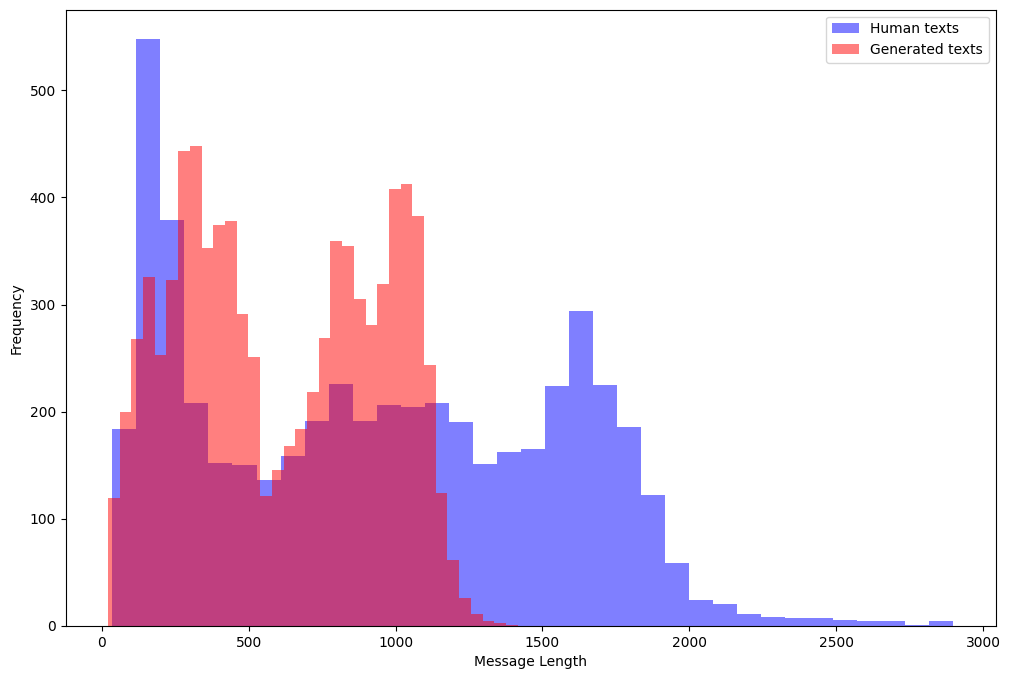

In [6]:
plt.figure(figsize=(12, 8))

train_eu_preprocessed[train_eu_preprocessed.label == 0].text_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Human texts', alpha=0.5)
train_eu_preprocessed[train_eu_preprocessed.label == 1].text_len.plot(bins=35, kind='hist', color='red', 
                                       label='Generated texts', alpha=0.5)
plt.legend()
plt.xlabel("Message Length")

In [7]:
def plot_common_words(ham_words, type):
    common_words = [word[0] for word in ham_words.most_common(20)]
    word_counts = [word[1] for word in ham_words.most_common(20)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(common_words, word_counts, color='skyblue')
    plt.title(f'Top 20 Most Common Words in {type} Labeled Data')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [8]:
words = train_eu_preprocessed[train_eu_preprocessed.label == 0]['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
ham_words_human = Counter()

for msg in words:
    ham_words_human.update(msg)
    
print(ham_words_human.most_common(50))

[('zeuden', 2087), ('egiten', 1743), ('bi', 1621), ('izango', 1587), ('behar', 1562), ('den', 1551), ('nahi', 1507), ('zituzten', 1459), ('baino', 1367), ('artean', 1305), ('kanpo', 1267), ('dut', 1151), ('estekak', 1151), ('esan', 1120), ('zion', 1118), ('euskal', 1096), ('duen', 1070), ('ari', 1064), ('oso', 1019), ('pertsona', 1010), ('baten', 1000), ('gainera', 972), ('bai', 968), ('gehiago', 954), ('nire', 949), ('lehen', 911), ('etxek', 903), ('bizi', 902), ('hartu', 897), ('zegoen', 883), ('dela', 852), ('eman', 850), ('gabe', 848), ('urte', 848), ('hiru', 847), ('etxebizitza', 830), ('gero', 826), ('diren', 825), ('gure', 802), ('ondoren', 802), ('zela', 800), ('lan', 787), ('joan', 775), ('hasi', 750), ('duten', 744), ('egun', 735), ('egiteko', 735), ('bakarrik', 724), ('arte', 722), ('a', 715)]


In [9]:
words = train_eu_preprocessed[train_eu_preprocessed.label == 1]['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
ham_words_computer = Counter()

for msg in words:
    ham_words_computer.update(msg)
    
print(ham_words_computer.most_common(50))

[('gure', 4552), ('euskal', 4353), ('izango', 3810), ('duen', 2873), ('nire', 2713), ('behar', 2597), ('egiten', 2378), ('hainbat', 2288), ('den', 2281), ('nahi', 2277), ('gaur', 2232), ('duzu', 2079), ('ezagutzen', 2051), ('oso', 1940), ('eman', 1794), ('dela', 1702), ('dugu', 1672), ('dut', 1667), ('bilboko', 1662), ('bi', 1652), ('daude', 1617), ('duten', 1587), ('artean', 1536), ('gehiago', 1529), ('zehar', 1413), ('ezin', 1412), ('aukera', 1399), ('herriko', 1398), ('bertan', 1376), ('esan', 1341), ('dituen', 1298), ('dituzte', 1282), ('egun', 1237), ('ematen', 1233), ('azken', 1204), ('euskara', 1201), ('batera', 1196), ('baino', 1187), ('dakit', 1162), ('horren', 1151), ('buruzko', 1121), ('ikusi', 1102), ('baten', 1101), ('diren', 1066), ('gora', 1048), ('zure', 1042), ('lan', 1041), ('baita', 1025), ('parte', 1023), ('hartu', 1004)]


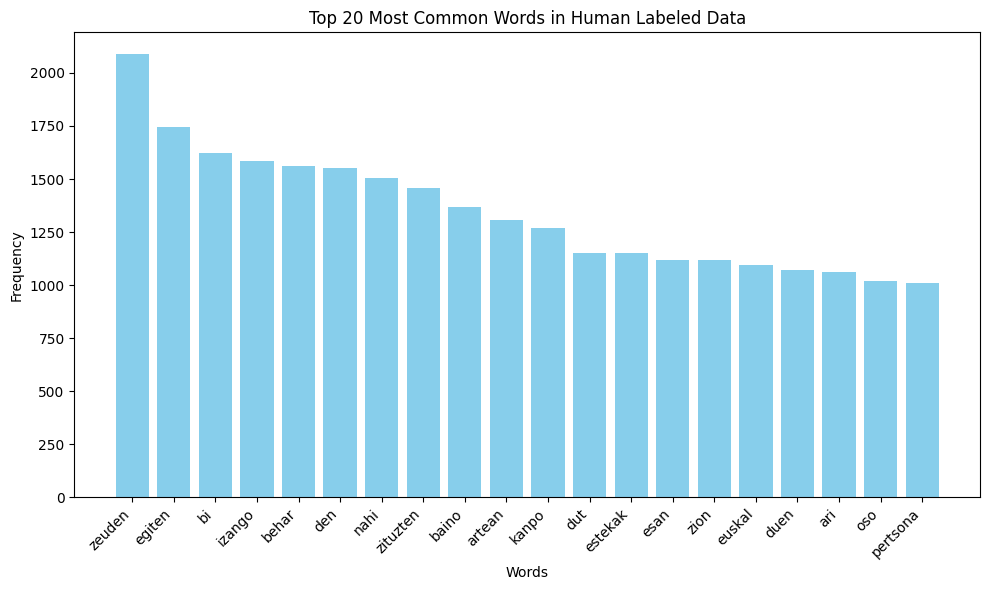

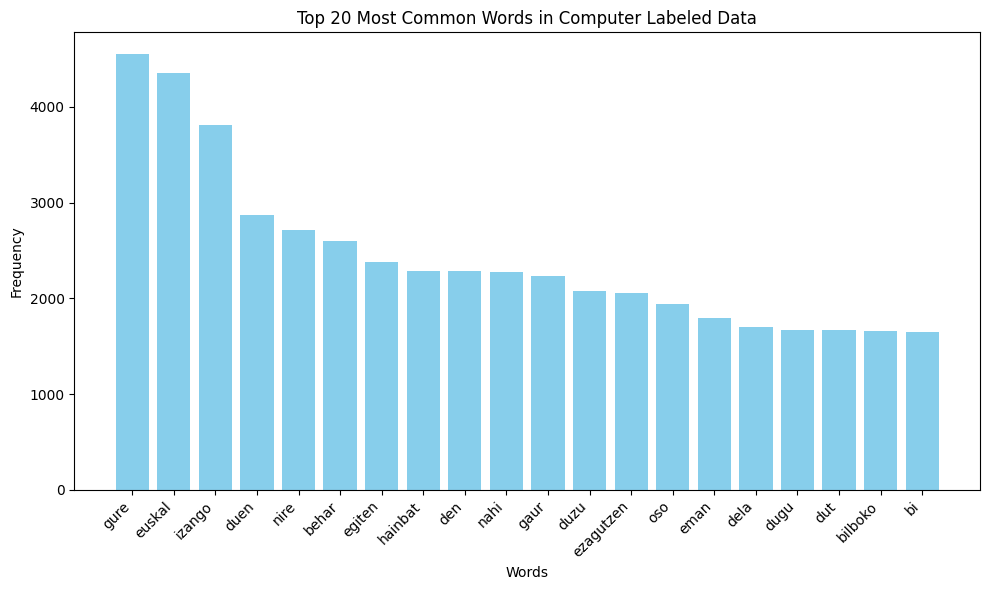

In [10]:
for counter in [(ham_words_human, 'Human'), (ham_words_computer, 'Computer')]:
    plot_common_words(counter[0], counter[1])

In [11]:
print(f"Average Human text length: {train_eu_preprocessed[train_eu_preprocessed.label == 0]['text_len'].mean()}")
print(f"Average Computer text length: {train_eu_preprocessed[train_eu_preprocessed.label == 1]['text_len'].mean()}")

Average Human text length: 941.9553339980059
Average Computer text length: 613.4098944121486


# First model

## Split

In [12]:
X_train_eu, X_test_eu, y_train_eu, y_test_eu = train_test_split(train_eu_preprocessed.loc[:, 'clean_text'], 
                                                                train_eu_preprocessed['label'], test_size=0.20, random_state=42)

print(X_train_eu.shape)
print(X_test_eu.shape)
print(y_train_eu.shape)
print(y_test_eu.shape)

(10755,)
(2689,)
(10755,)
(2689,)


In [13]:
X_train_eu

7074     Alcañizo toledoko udalerria campana de oropesa...
1886     Jessica hausner atzean geratzen analisian fabu...
8440     Euskal herria bilboako arriaga antzoki batzuke...
1339     Alcollarín cáceresko probintziako udalerria cá...
13290    Tuapamizaga dunezko epea erabiliz daitezke hor...
                               ...                        
5191     Kapitulua korrika haren atzetik dabilela burut...
13418    Elikagai gorlizko kulturetxe udaleko atarikoan...
5390     Gabon zorionak ianiire4 espero dut zure eguna ...
860      Gerraz hitz egiten goseaz gurasoen antza izate...
7270     Eusko label ligan parte hartzen duten h amabi ...
Name: clean_text, Length: 10755, dtype: object

In [14]:
y_train_eu

7074     0
1886     1
8440     1
1339     0
13290    1
        ..
5191     1
13418    1
5390     0
860      0
7270     1
Name: label, Length: 10755, dtype: int64

## Models

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train_eu)

# learn training data vocabulary, then use it to create a document-term matrix
X_train1_dtm = vect.transform(X_train_eu)

# equivalently: combine fit and transform into a single step
X_train1_dtm = vect.fit_transform(X_train_eu)


# examine the document-term matrix
print(type(X_train1_dtm), X_train1_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test1_dtm = vect.transform(X_test_eu)
print(type(X_test1_dtm), X_test1_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (10755, 125570)
<class 'scipy.sparse._csr.csr_matrix'> (2689, 125570)


### Logistic Regression Model

In [16]:
# import an instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

# train the model using X_train_dtm
%time logreg.fit(X_train1_dtm, y_train_eu)

CPU times: total: 3.61 s
Wall time: 1.89 s


LogisticRegression(solver='liblinear')

In [17]:
# make class predictions for X_test_dtm
y_test_eu_pred_lr = logreg.predict(X_test1_dtm)

# calculate predicted probabilities for X_test_dtm (well calibrated)
y_test_eu_prob_lr = logreg.predict_proba(X_test1_dtm)[:, 1]
y_test_eu_prob_lr

array([0.23841136, 0.96653087, 0.00248869, ..., 0.99968466, 0.03111037,
       0.83387149])

In [18]:
# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test_eu, y_test_eu_pred_lr))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test_eu, y_test_eu_pred_lr))

# calculate AUC
print("=======ROC AUC Score===========")
print(metrics.roc_auc_score(y_test_eu, y_test_eu_pred_lr))

=======Accuracy Score===========
0.920416511714392
=======Confision Matrix===========
[[ 884  121]
 [  93 1591]]
=======ROC AUC Score===========
0.9121881684215503


In [19]:
from sklearn.metrics import f1_score
print(f"F1-score for Logistic Regression model: {f1_score(y_test_eu, y_test_eu_pred_lr, average='macro')}")

F1-score for Logistic Regression model: 0.9145064710783387
